In [1]:
# the purpose of this notebook is to test and time alternative lung masking techniques
import os                                   # do directory ops
import math                                 # used for ceil ops
import datetime                             # used for saving with a datetime string
import pandas as pd                         # data analysis
import numpy as np                          # array ops
import matplotlib.pyplot as plt             # used for visualization in dev
import pydicom                              # for reading dicom files
from cv2 import resize, threshold, THRESH_OTSU           # image processing
from skimage import morphology, measure     # for lung masking
from skimage.transform import rescale, resize
from sklearn.cluster import KMeans          # for lung masking
from tqdm import tqdm                       # for progress bars
import seaborn as sns
import cv2

import sys
# import current lungmask technique
sys.path.insert(1, '/Users/jesse/Documents/osic_kaggle/scripts')
from pre_proc import make_lungmask
from random import choice

In [2]:
# new method using otsu's thresholding
def make_lungmask_v2(img):

    # Rescale pixels to 255
    img_2d = img.astype(float)                            
    im_min = np.min(img_2d) # many are not windowed and have vals < 0
    if im_min < 0:
        img_2d = img_2d - im_min
    img = (np.maximum(img_2d,0) / img_2d.max()) * 255.0

    # otsu's binarization thresholding
    thresh, thresh_img = threshold(img.astype('uint8'), np.min(img), np.max(img), THRESH_OTSU)
    # rescale to binary and invert
    thresh_img = np.where(thresh_img==0,1,0)

    ###########################################

    # now copy functionality from the old method to achieve a mask
    row_size= img.shape[0]
    col_size = img.shape[1]

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.
    erosion = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(erosion,np.ones([15,15]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    labels = labels + 1 # add 1 to every element so that the background is no longer encoded as 0
    regions = measure.regionprops(labels) # for some reason ignores labels marked 0
    good_labels = []
    n_px = len(img.flatten())
    for prop in regions:
        B = prop.bbox # (min_row, min_col, max_row, max_col)
        # region width < 90% of img
        # region height < 90% of img
        # min row > 15%, max row < 85%
        # min col < 15%, max col < 85%
        # region area is > 0.1% of img
        if B[2]-B[0]<row_size*.90 and \
            B[3]-B[1]<col_size*.90 and \
            B[0]>row_size*.075 and B[2]<row_size*.925 and \
            B[1]>col_size*.075 and B[3]<col_size*925 and \
            prop.area/n_px*100 > 0.1:
            good_labels.append(prop.label) 
            #print(f'prop {prop.label} area: {np.round(prop.area/n_px*100,2)}, {B}')
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([5,5])) # one last dilation

    # final masked image
    masked_img = mask*img
    mask_var = np.round(np.var(mask), 4)
    n_labels = len(good_labels)

    return masked_img, mask_var, n_labels

In [5]:
# prepare random patient folder of images for processing
dicom_dir = "/Users/jesse/Documents/osic_kaggle/data/train/"
patients = os.listdir(dicom_dir) # list of training patient IDS (folders which contain DICOMS)
patient = choice(patients)
path = dicom_dir + patient
dicoms = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
dicoms.sort(key=lambda x: int(x.ImagePositionPatient[2]))

slices = [dicom.pixel_array for dicom in dicoms]
print(f'Patient: {patient}; n CTs: {len(slices)}')

Patient: ID00216637202257988213445; n CTs: 21


In [6]:
%%time

# ORIGINAL METHOD USING KMEANS FOR THRESHOLDING
old_mask_results = []
for ct_scan in tqdm(slices):
    old_mask_results.append(make_lungmask(ct_scan))

100%|██████████| 21/21 [00:06<00:00,  3.32it/s]CPU times: user 42.3 s, sys: 2.2 s, total: 44.5 s
Wall time: 6.33 s



In [7]:
%%time

# NEW METHOD USING OTSU'S BINARIZATION FOR THRESHOLDING
new_mask_results = []
for ct_scan in tqdm(slices):
    new_mask_results.append(make_lungmask_v2(ct_scan))

100%|██████████| 21/21 [00:01<00:00, 15.76it/s]CPU times: user 1.63 s, sys: 103 ms, total: 1.74 s
Wall time: 1.34 s



In [8]:
def valid_mask(mask_var, n_labels):
    # evaluates a single CT slice to assess if the masking did a good job
    if mask_var > .04 and n_labels < 10:
        return True
    return False

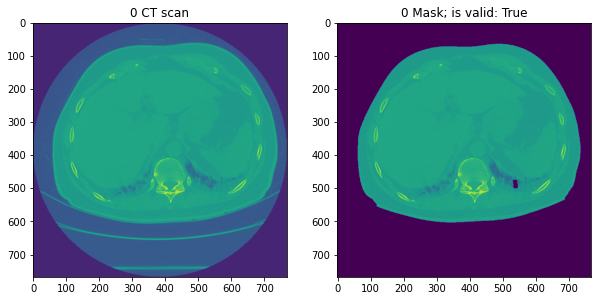

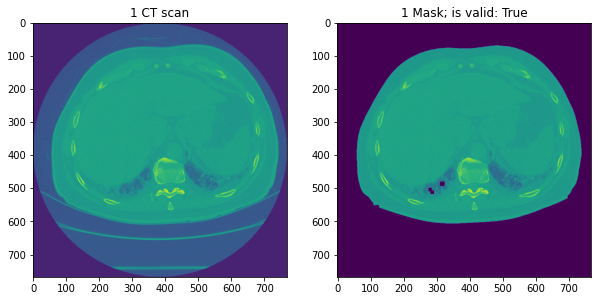

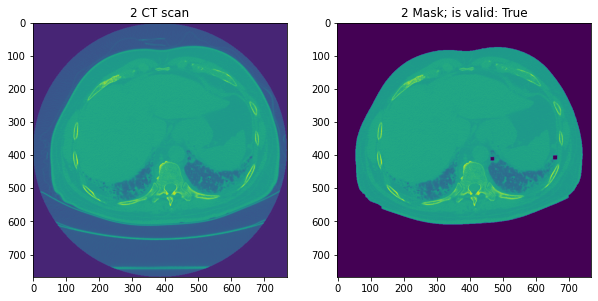

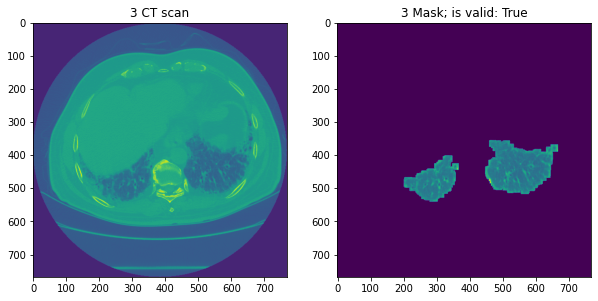

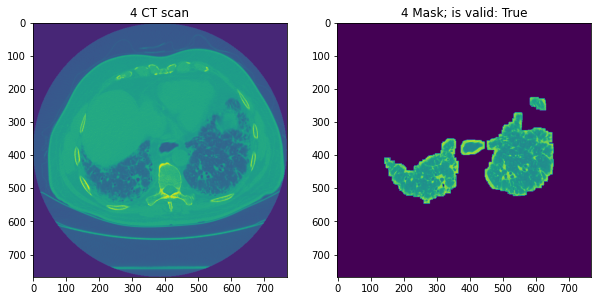

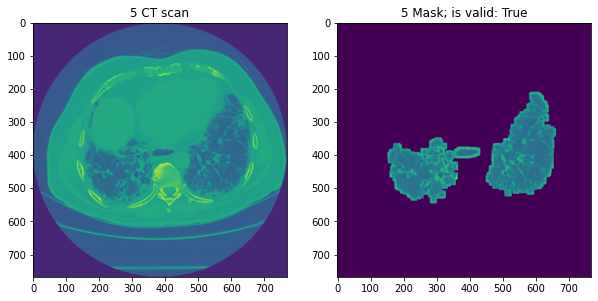

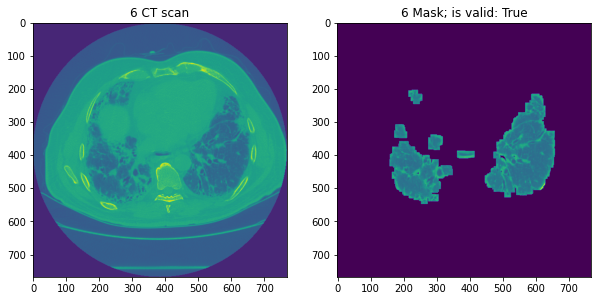

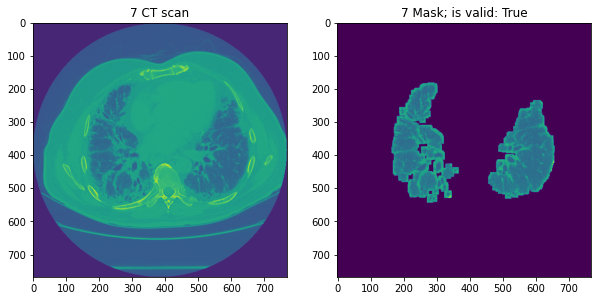

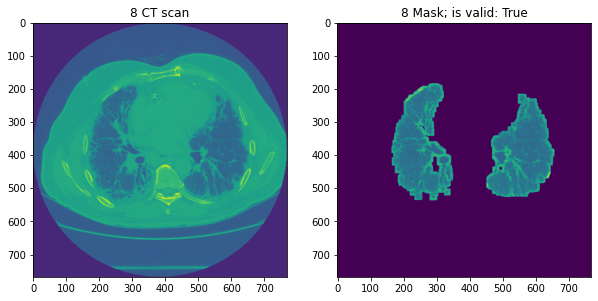

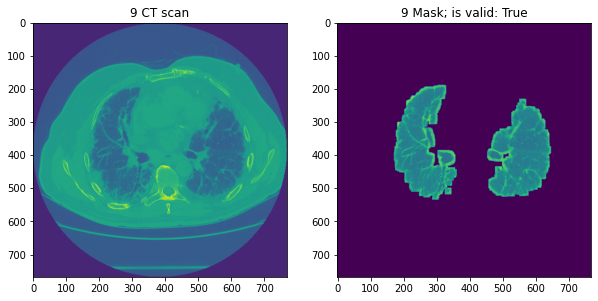

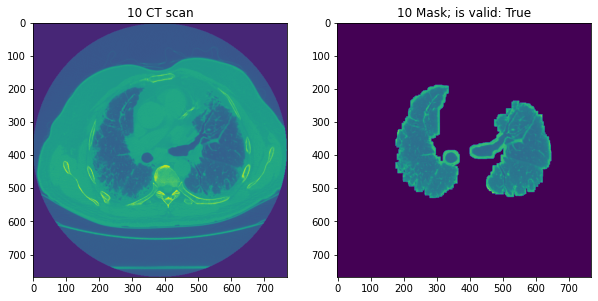

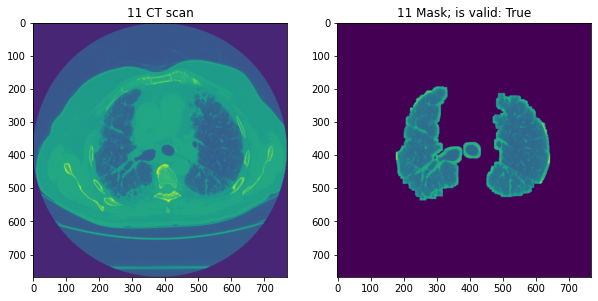

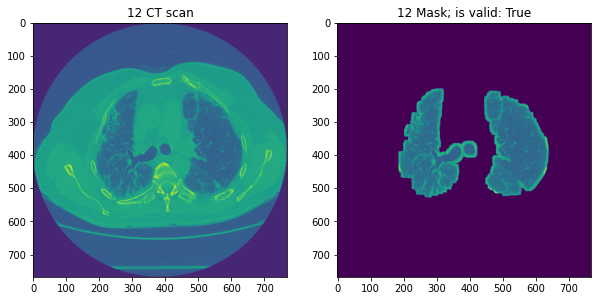

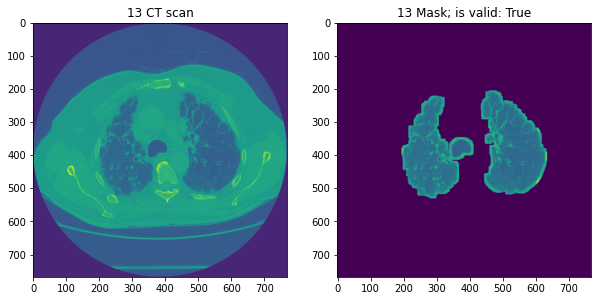

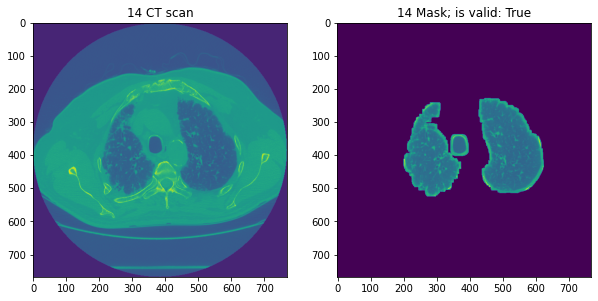

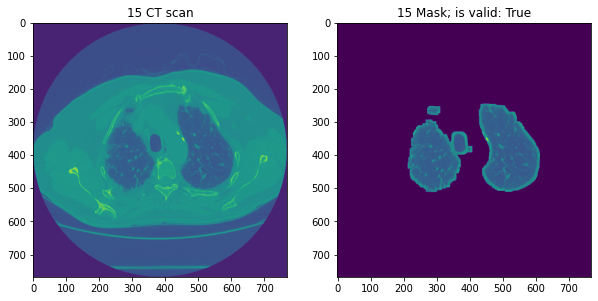

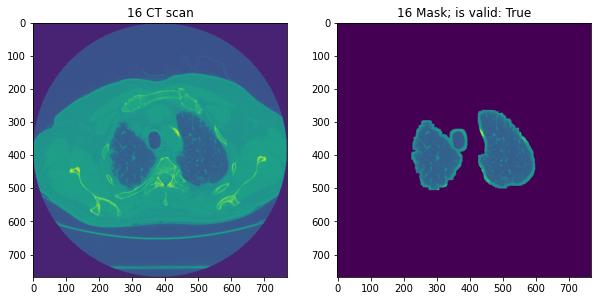

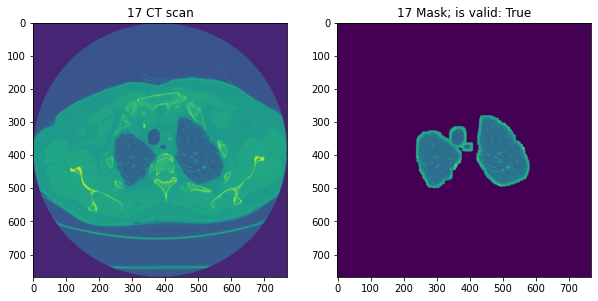

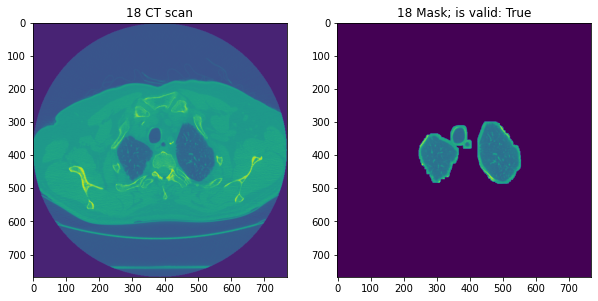

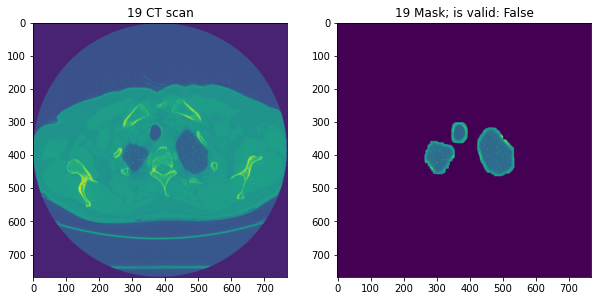

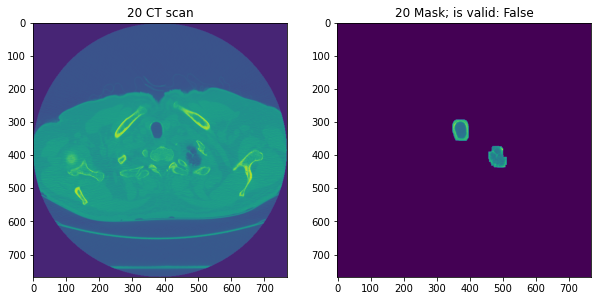

In [13]:
# View patient scan masks
N_SLICES = len(slices)
N_FIG_COLS = 2
N_FIG_ROWS = int(np.ceil(N_SLICES/N_FIG_COLS))

for i in range(N_SLICES):
    masked_img, mask_var, n_labels = new_mask_results[i]
    fig, ax = plt.subplots(ncols=N_FIG_COLS, nrows=1, figsize=(10,20))
    ax[0].imshow(slices[i])
    ax[0].set_title(f'{i} CT scan')
    ax[1].imshow(masked_img)
    ax[1].set_title(f'{i} Mask; is valid: {valid_mask(mask_var, n_labels)}')
    plt.show()